# 0. Import packages

In [1]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# 1. Load image embedding from layer activation

In [2]:
def get_path_img_emb_from_layer_act(model_nickname, layer, dim):
    return f'/raid/NeuEvo/data/img_act_emb/{model_nickname}/data/{layer}/img_emb-dim=30.txt'

def load_img_emb_from_layer_act(model_nickname, layer, dim):
    p = get_path_img_emb_from_layer_act(model_nickname, layer, dim)
    data = np.loadtxt(p)
    return data

In [3]:
model_nickname = 'vgg19_pretrained'
layer = 'Sequential_0_Conv2d_34'
dim = 30

img_emb = load_img_emb_from_layer_act(model_nickname, layer, dim)

In [4]:
img_emb.shape

(1281167, 30)

# 2. Can image embedding (from layer activation) approximate the similarity between images?

## 2-1. Showing training images given image indices

In [5]:
raw_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

raw_training_datasets = datasets.ImageFolder(
    '../../../../ILSVRC2012/train',
    raw_data_transform
)

def show_imgs(img_idxs):
    for img_idx in img_idxs:
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        plt.title(f'img: {img_idx}')
        plt.imshow(img)
        plt.show()
        
def show_np_imgs_2_rows(imgs, title=None, subplot_titles=None):
    # Create figure
    nrows = 2
    ncols = len(imgs) // nrows
    fig, ax = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    fig.tight_layout()
    
    # Create subplots
    for i, img in enumerate(imgs[:nrows * ncols]):
        row = int(i / ncols)
        col = i - row * ncols
        ax[row, col].imshow(img) 
        ax[row, col].set_axis_off()
        if subplot_titles is not None:
            ax[row, col].set_title(subplot_titles[i])

    # Title
    if title is not None:
        fig.suptitle(title, y=1.06)
        
    # Show the final plot
    plt.show()
        
def show_imgs_2_rows(img_idxs, title=None):
    # Images
    imgs = []
    subplot_titles = []
    for i, img_idx in enumerate(img_idxs):
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        imgs.append(img)
        subplot_titles.append(f'{i}-th img: {img_idx}')
        
    # Show images
    show_np_imgs_2_rows(imgs, title=title, subplot_titles=subplot_titles)

## 2-2. Pick an image, and find the most similar images based on the image embedding from layer activation

Sampled image index: 55037


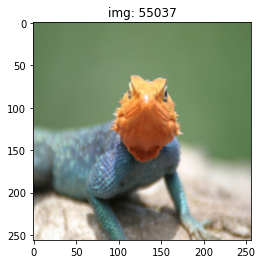

In [15]:
# Sampled image

num_imgs = img_emb.shape[0]
sampled_img_idx = np.random.choice(num_imgs)
print(f'Sampled image index: {sampled_img_idx}')
show_imgs([sampled_img_idx])

In [16]:
def cos_sim(v, w):
    n_v = np.linalg.norm(v)
    n_w = np.linalg.norm(w)
    if n_v <= 0 or n_w <= 0:
        return 0
    return v.dot(w) / (n_v * n_w)

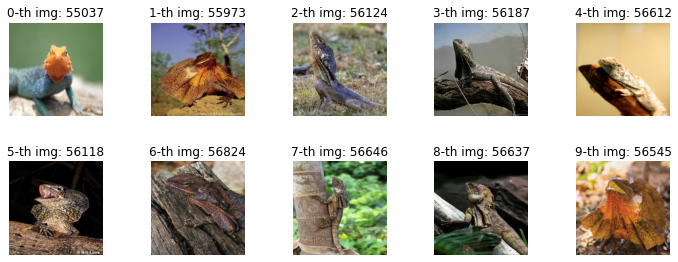

In [17]:
# Find top 10 similar images
sim_d = {}
sampled_img_v = img_emb[sampled_img_idx]
for img_idx, img_v in enumerate(img_emb):
    sim_d[img_idx] = cos_sim(sampled_img_v, img_v)

sorted_sim = sorted(sim_d.items(), key=lambda x:x[1], reverse=True)
top10_imgs = {t[0]: t[1] for t in sorted_sim[:10]}

show_imgs_2_rows(top10_imgs)

# 3. Can image embedding (from layer activation) approximate the similarity between neurons in different models?

# 3-1. Load stimulus

In [18]:
def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

def get_stimulus_path(model_nickname, topk_s):
    return f'/raid/NeuEvo/data/stimulus/{model_nickname}/data/stimulus-topk_s={topk_s}.json'

def load_stimulus(model_nickname, topk_s):
    p = get_stimulus_path(model_nickname, topk_s)
    data = load_json(p)
    return data

In [19]:
model_nickname_1 = 'vgg19_pretrained'
model_nickname_2 = 'convnext_0.004_96'

topk_s = 20

stimulus_1 = load_stimulus(model_nickname_1, topk_s)
stimulus_2 = load_stimulus(model_nickname_2, topk_s)

## 3-2. Sample a neuron from model 1

In [20]:
def sample_layer(stimulus):
    layers = list(stimulus.keys())
    sampled_layer = np.random.choice(layers)
    return sampled_layer

def sample_neuron(stimulus):
    sampled_layer = sample_layer(stimulus)
    num_neurons = len(stimulus[sampled_layer])
    sampled_neuron = np.random.choice(num_neurons)
    neuron_id = f'{sampled_layer}-{sampled_neuron}'
    return neuron_id

In [22]:
def get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio):
    root = '/raid/NeuEvo/data/neuron_feature'
    return f'{root}/{model_nickname}/data/topk_s={topk_s}-ex_patch_size_ratio={ex_patch_size_ratio}'

def get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    d = get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio)
    paths = []
    for i in range(topk_s):
        paths.append(f'{d}/{layer}-{neuron_idx}-{i}.jpg')
    return paths

def load_img_from_path(p):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
                     
def show_ex_patch(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    img_ps = get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx)
    imgs = [load_img_from_path(img_path) for img_path in img_ps]
    title = f'{model_nickname}, {layer}-{neuron_idx}'
    show_np_imgs_2_rows(imgs, title=title, subplot_titles=None)

In [57]:
sampled_neuron_id_1 = sample_neuron(stimulus_1)
sampled_neuron_id_1

'Sequential_0_Conv2d_34-392'

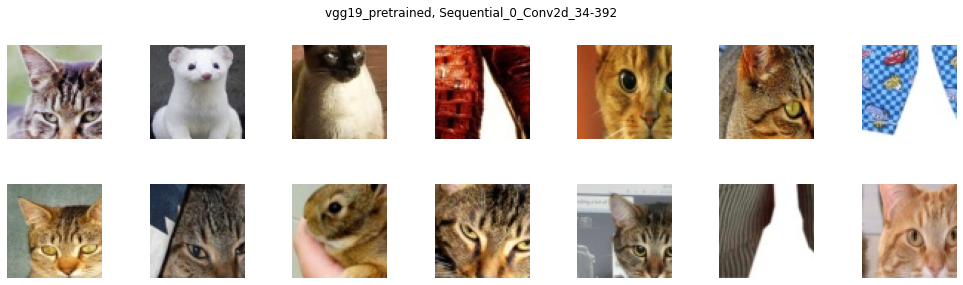

In [58]:
ex_patch_size_ratio = 0.3
sampled_neuron_layer, sampled_neuron_idx = sampled_neuron_id_1.split('-')
sampled_neuron_idx = int(sampled_neuron_idx)
show_ex_patch(model_nickname_1, 15, ex_patch_size_ratio, sampled_neuron_layer, sampled_neuron_idx)

## 3-3. Find neurons in model 2 that are similar to the sampled neuron in model 1

In [60]:
class TopKKeeper:
    """
    Keep k (key, val, content) paris, where they are sorted in the descending 
    order. If a new inserted pair (key', val', content') has lower value than 
    the minimum value of the item (i.e., val' < min val), it won't be inserted.
    Content is optional.
    """
    
    def __init__(self, k):
        self.k = k
        self.keys = []
        self.vals = []
        self.contents = []


    def will_insert(self, val):
        if len(self.vals) < self.k:
            return True
        elif self.vals[-1] < val:
            return True
        return False

        
    def insert(self, val, key=None, content=None):
        # Check whether we want to insert the item or not
        if not self.will_insert(val):
            return
        
        # Insert
        reach_end = True
        for i, e in enumerate(self.vals):
            if e < val:
                if key is not None:
                    self.keys = self.keys[:i] + [key] + self.keys[i:]
                    self.keys = self.keys[:self.k]

                self.vals = self.vals[:i] + [val] + self.vals[i:]
                self.vals = self.vals[:self.k]

                if content is not None:
                    self.contents = \
                        self.contents[:i] + [content] + self.contents[i:]
                    self.contents = self.contents[:self.k]

                reach_end = False
                break
        if reach_end:
            if key is not None:
                self.keys.append(key)
                self.keys = self.keys[:self.k]

            self.vals.append(val)
            self.vals = self.vals[:self.k]

            if content is not None:
                self.contents.append(content)
                self.contents = self.contents[:self.k]

In [62]:
def get_avg_img_emb(stimuli, dim, img_emb):
    avg_v = np.zeros(dim)
    for img in stimuli:
        v = img_emb[img]
        avg_v += v
    avg_v = avg_v / len(stimuli)
    return avg_v

In [65]:
sampled_neuron_stimuli = stimulus_1[sampled_neuron_layer][sampled_neuron_idx]
sampled_neuron_v = get_avg_img_emb(sampled_neuron_stimuli, dim, img_emb)

dim = 30
topk_keeper = TopKKeeper(10)
for layer in stimulus_2:
    for neuron_idx, neuron_stimuli in enumerate(stimulus_2[layer]):
        avg_v = get_avg_img_emb(neuron_stimuli, dim, img_emb)
        sim = cos_sim(sampled_neuron_v, avg_v)
        topk_keeper.insert(sim, key=f'{layer}-{neuron_idx}')
        
print(topk_keeper.keys)
print(topk_keeper.vals)

['features_5_blk_1-128', 'features_5_blk_4-128', 'features_7_blk_2-39', 'features_6_blk_1-410', 'features_5_blk_8-303', 'features_5_blk_8-376', 'features_5_blk_8-221', 'features_6_blk_1-289', 'features_5_blk_7-247', 'features_7_blk_1-13']
[0.9995954415861367, 0.99958043161047, 0.9995425520826128, 0.9995174325569551, 0.9994685457854848, 0.9994439369207545, 0.9994417622475927, 0.9994213736451004, 0.9993894324172365, 0.999334410858316]


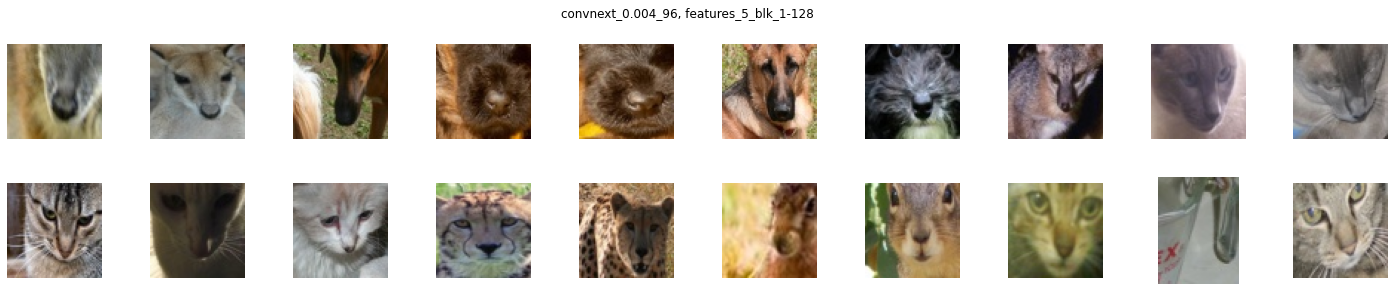

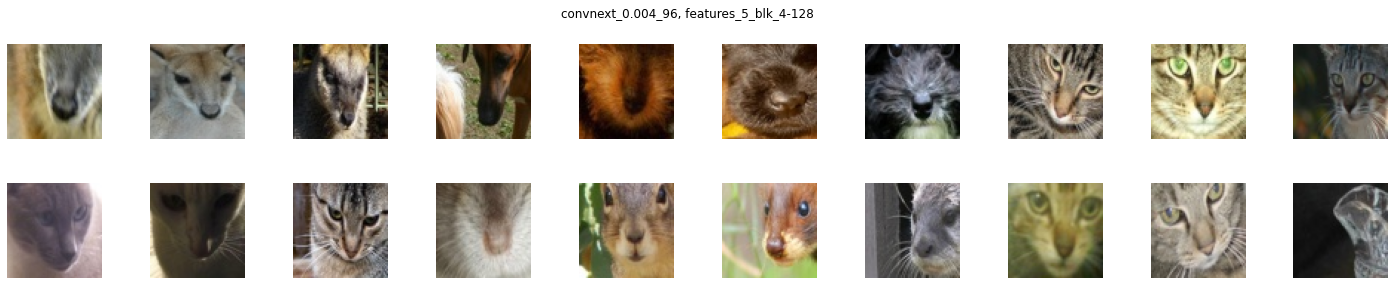

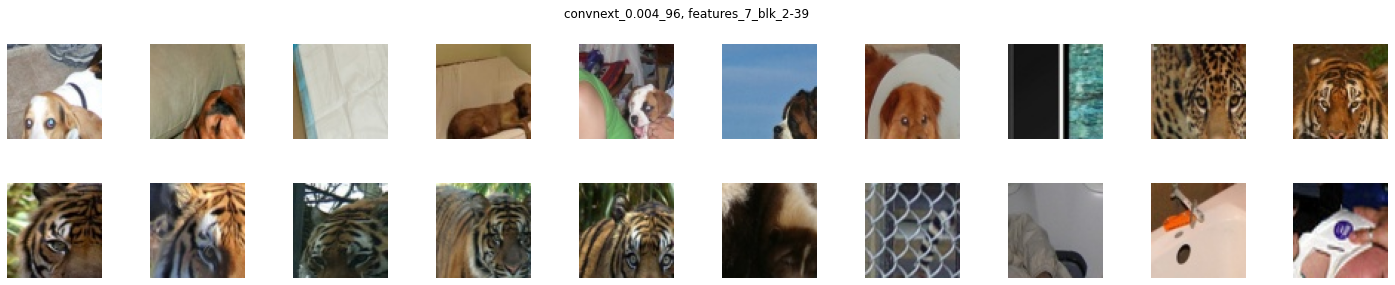

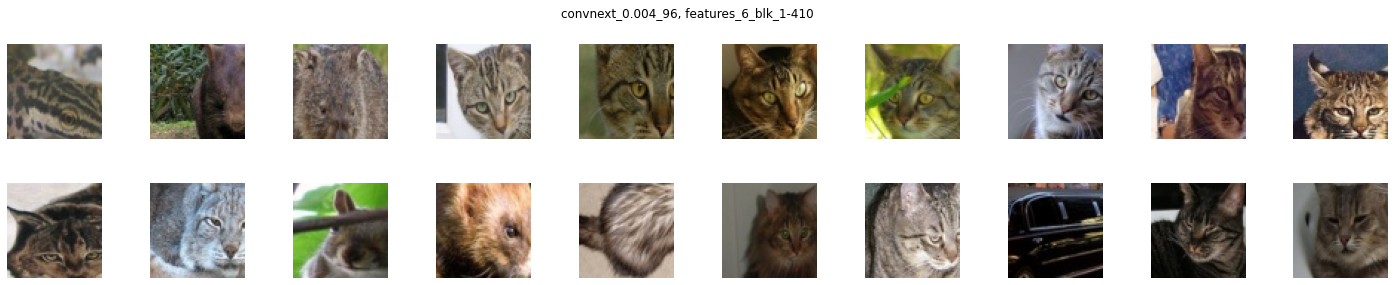

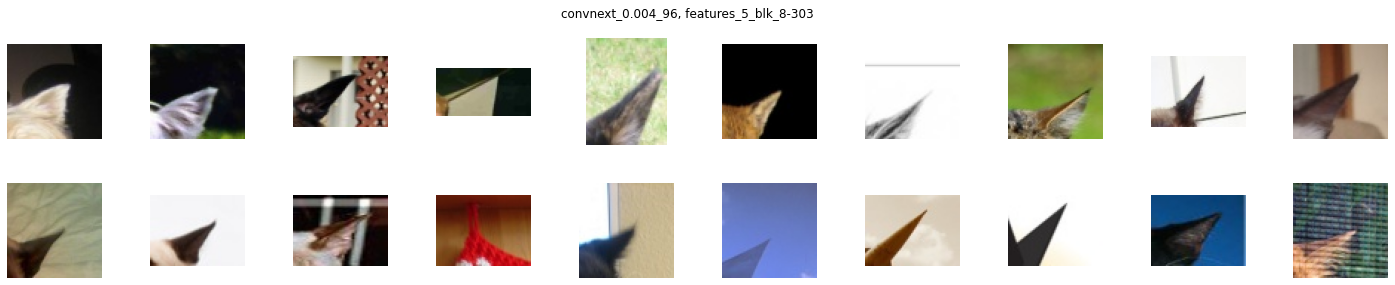

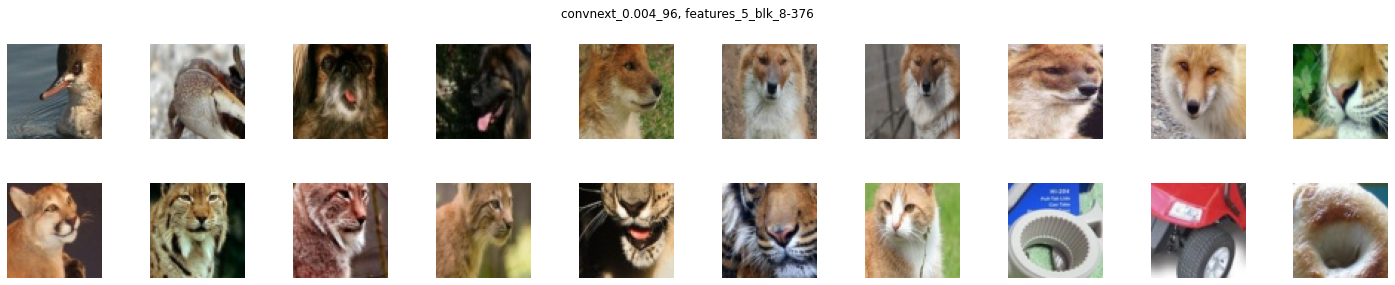

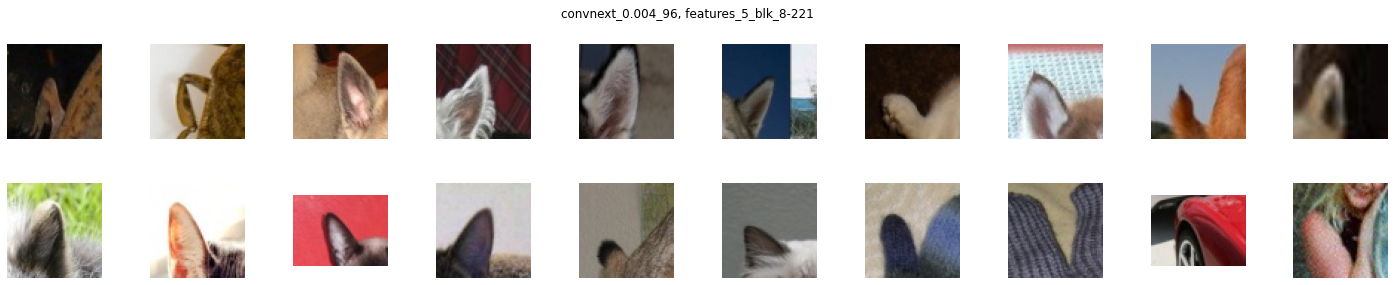

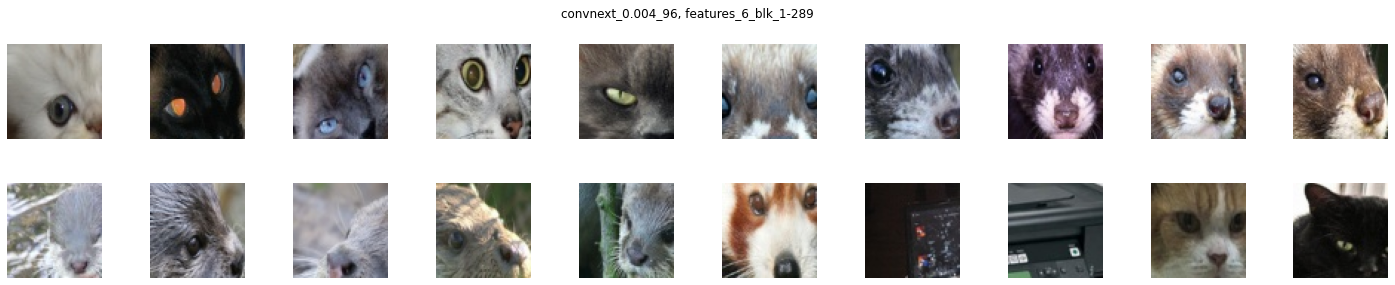

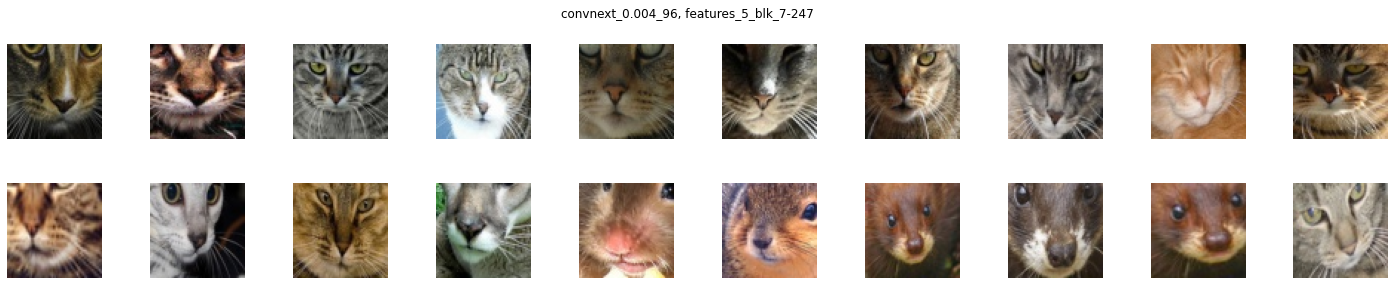

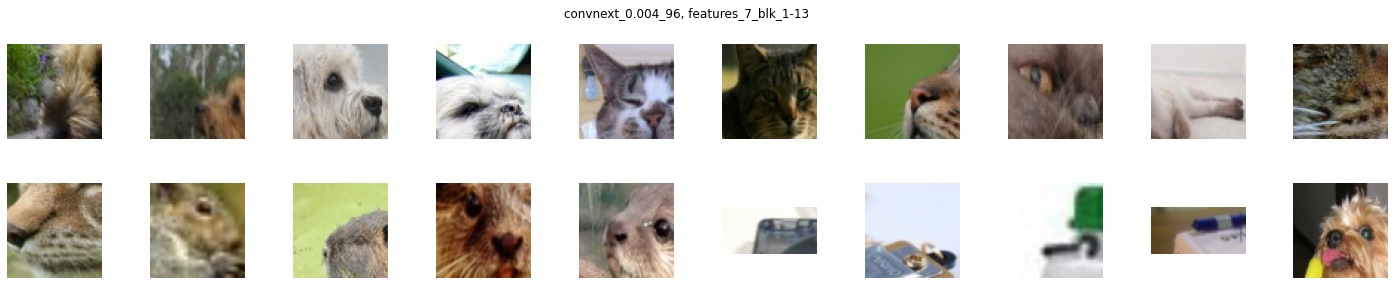

In [66]:
similar_neurons = topk_keeper.keys
topk_s = 20
for neuron in similar_neurons:
    layer, idx = neuron.split('-')
    idx = int(idx)
    show_ex_patch(
        model_nickname_2, 
        topk_s, 
        ex_patch_size_ratio, 
        layer, 
        idx
    )

In [68]:
for layer in stimulus_1.keys():
    print(layer)

Sequential_0_Conv2d_0
Sequential_0_Conv2d_2
Sequential_0_Conv2d_5
Sequential_0_Conv2d_7
Sequential_0_Conv2d_10
Sequential_0_Conv2d_12
Sequential_0_Conv2d_14
Sequential_0_Conv2d_16
Sequential_0_Conv2d_19
Sequential_0_Conv2d_21
Sequential_0_Conv2d_23
Sequential_0_Conv2d_25
Sequential_0_Conv2d_28
Sequential_0_Conv2d_30
Sequential_0_Conv2d_32
Sequential_0_Conv2d_34
